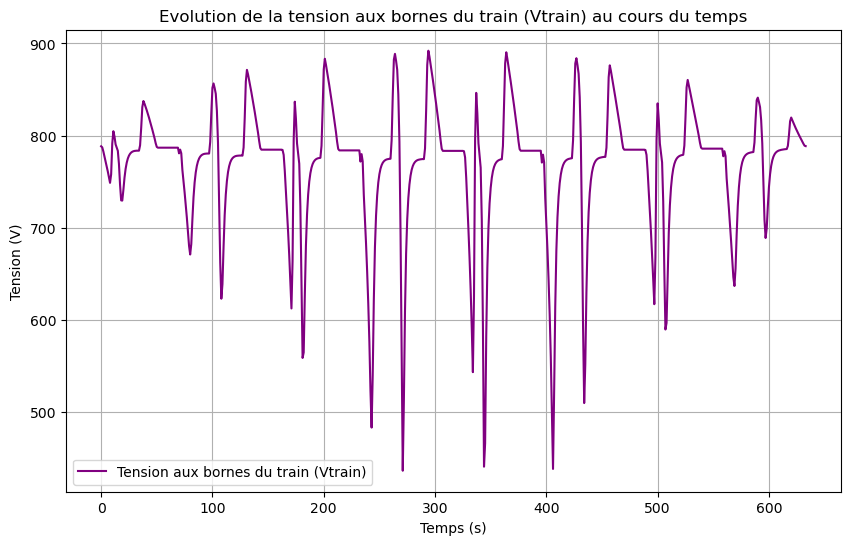

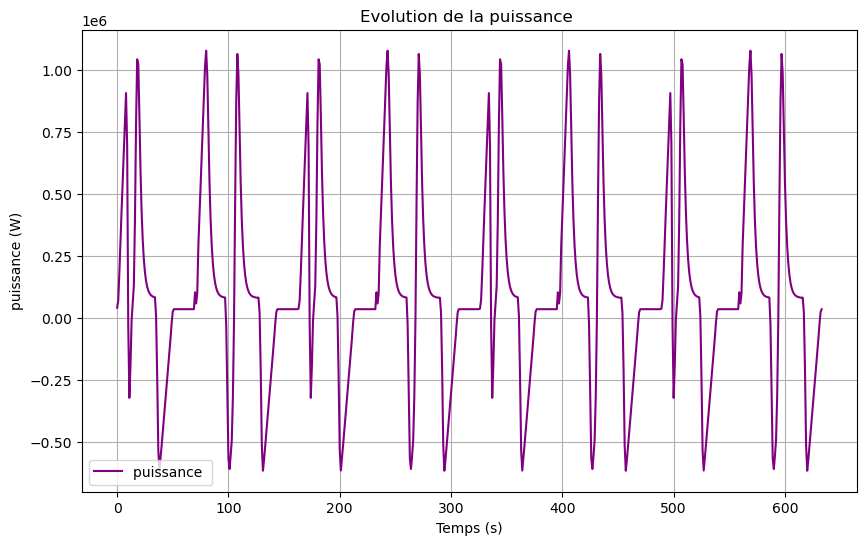

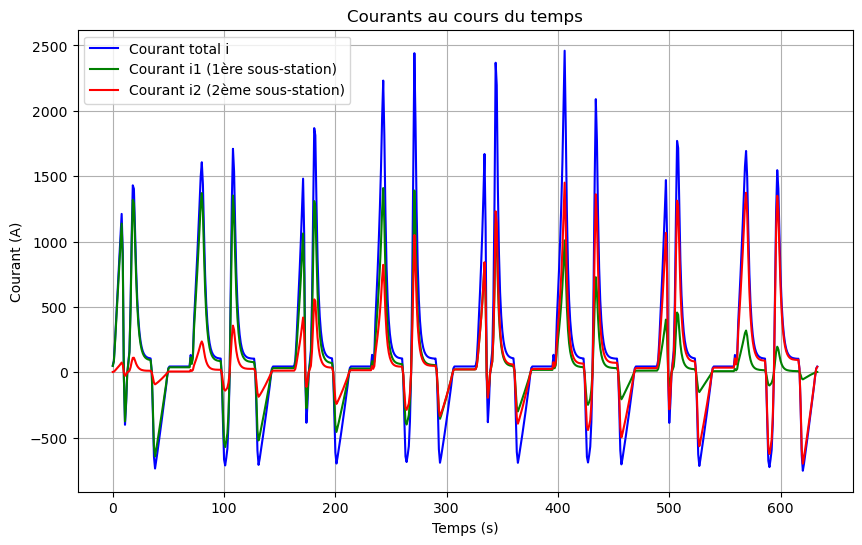

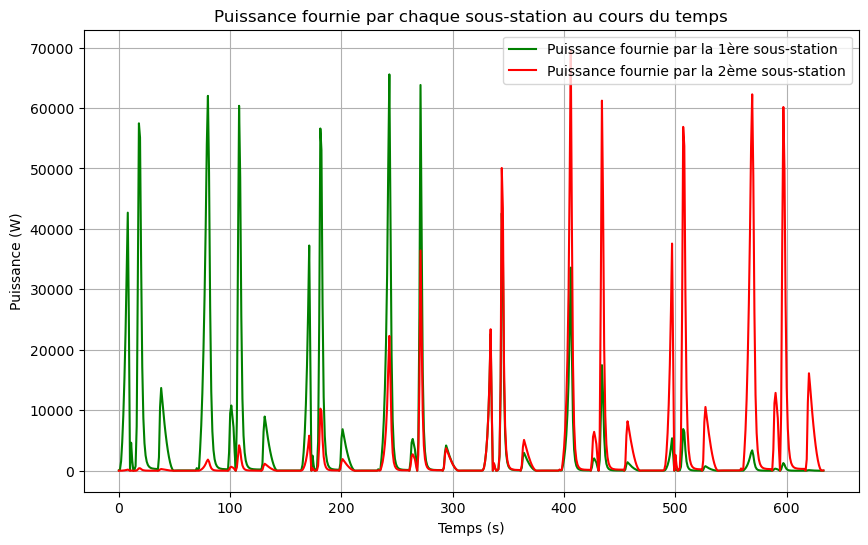

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour calculer RLAC et Rrail
def calculer_RLAC(x):
    return RLAC_per_m * x

def calculer_Rrail(x):
    return Rrail_per_m * x

# Fonction pour calculer Req
def calculer_Req(x):
    RLAC1 = calculer_RLAC(x)
    Rrail1 = calculer_Rrail(x)
    RLAC2 = calculer_RLAC(5000 - x)  # Longueur totale de 5 km
    Rrail2 = calculer_Rrail(5000 - x)
    R1 = RLAC1 + Rrail1 + Rsst
    R2 = RLAC2 + Rrail2 + Rsst
    return ( (R1*R2)/(R1 + R2 ) )

# Fonction pour calculer la puissance mécanique
def calculer_puissance_mecanique(temps, position_x):
    vitesse = np.gradient(position_x, temps)
    acceleration = np.gradient(vitesse, temps)

    # Paramètres pour le calcul de la force résistive
    M = 70000 
    Ao = 780
    A1 = 6.4
    Bo = 0
    B1 = 0.14
    Co = 0.3634
    C1 = 0

    # Force résistive
    Fresistive = (Ao + A1 * M/1000) + (Bo + B1 * M/1000) * 3.6*vitesse + (Co + C1 * M/1000) * (3.6*vitesse)**2

    # Force motrice
    Fmotrice = M * acceleration + M * 9.81 * np.sin(0) + Fresistive  # En supposant une pente nulle pour le moment

    Pmechanique = Fmotrice * vitesse
    return Pmechanique


# Données du problème
Vsst = 790  
Rsst = 33e-3  
RLAC_per_m = 95e-6  
Rrail_per_m = 10e-6  

# Charger les données de la marche du train
data = np.loadtxt('marche_train.txt')  
temps = data[:, 0]
position_x = data[:, 1] 

Pmechanique = calculer_puissance_mecanique(temps, position_x)



Ptrain = []
for p_mechanique in Pmechanique:
    if p_mechanique >= 0:
        Ptrain.append(p_mechanique / 0.80 + 35000)
    else:
        Ptrain.append(p_mechanique * 0.80 + 35000)
  
  

# 1. Calcul de Vtrain
Vtrain = []
for idx in range(len(temps)):
    x = position_x[idx]
    Req = calculer_Req(x)
    P = Ptrain[idx]
    delta = Vsst**2 - 4 * Req * P
    if delta >= 0:
        V = 0.5 * (Vsst + np.sqrt(delta))
        Vtrain.append(V)
    else:
        Vtrain.append(np.nan)

# 2. Calcul des courants et des puissances (en dehors de la boucle de Vtrain)
i  = []
i1 = []
i2 = []
P1 = []
P2 = []

for idx in range(len(temps)):
    x = position_x[idx]
    Req = calculer_Req(x)
    P = Ptrain[idx]
    V = Vtrain[idx]
    i_value = (Vsst - V) / Req
    i.append(i_value)
    # Calcul des courants i1 et i2
    i1_value = (Vsst - V) / (Rsst + calculer_RLAC(x) + calculer_Rrail(x))
    i2_value = (Vsst - V) / (Rsst + calculer_RLAC(5000 - x) + calculer_Rrail(5000 - x))
    P1_value = (Rsst ) * i1_value**2 
    P2_value = (Rsst ) * i2_value**2 
    i1.append(i1_value)
    i2.append(i2_value)
    P1.append(P1_value)
    P2.append(P2_value)

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(temps, Vtrain, label='Tension aux bornes du train (Vtrain)', color='purple')
plt.title('Evolution de la tension aux bornes du train (Vtrain) au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Tension (V)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(temps, Ptrain, label='puissance ', color='purple')
plt.title('Evolution de la puissance ')
plt.xlabel('Temps (s)')
plt.ylabel('puissance (W)')
plt.legend()
plt.grid(True)
plt.show()

# Tracer les courants (i, i1, i2)
plt.figure(figsize=(10, 6))
plt.plot(temps, i, label='Courant total i', color='blue')
plt.plot(temps, i1, label='Courant i1 (1ère sous-station)', color='green')
plt.plot(temps, i2, label='Courant i2 (2ème sous-station)', color='red')
plt.title('Courants au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Courant (A)')
plt.legend()
plt.grid(True)
plt.show()

# Tracer les puissances (P1 et P2)
plt.figure(figsize=(10, 6))
plt.plot(temps, P1, label='Puissance fournie par la 1ère sous-station', color='green')
plt.plot(temps, P2, label='Puissance fournie par la 2ème sous-station', color='red')
plt.title('Puissance fournie par chaque sous-station au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.legend()
plt.grid(True)
plt.show()


In [139]:
def gestion_puissances(P_seil, train_demand, battery_level, battery_capacity, battery_output_capacity, battery_input_capacity, Dt=1, battery_efficiency=0.9):
    P_LAC = 0.0
    P_battery = 0.0
    P_rheostat = 0.0
    
    # Phase de consommation élevée (accélération ou forte demande)
    if train_demand >= P_seil:
        # Puissance cible que la batterie doit fournir :
        target_battery_power = train_demand - P_seil
        max_battery_power = min(battery_output_capacity, battery_level / Dt)
        requested_discharge = min(target_battery_power, max_battery_power)

        # The actual power delivered to the train is battery_efficiency * requested_discharge
        # but to keep consistent with the usage in controlling flows, we treat P_battery as
        # the power "seen" from the system perspective.
        # We'll handle the battery_level update with efficiency separately.
        P_battery = requested_discharge
                
        # Si la batterie ne peut pas fournir toute la différence, on ajuste la LAC :
        if P_battery < target_battery_power:
            # Complément de puissance à fournir par la LAC
            P_LAC = P_seil + (target_battery_power - P_battery)
        else:
            # La batterie couvre entièrement la différence : la LAC fournit uniquement P_seil
            P_LAC = P_seil
        
        # Dans tous les cas, le rhéostat ne consomme pas ici
        P_rheostat = 0






    elif 0 < train_demand < P_seil:
        # Demande modérée : la LAC couvre cette demande entièrement
        P_LAC = train_demand
        P_battery = 0
        P_rheostat = 0


    else:
        # train_demand <= 0 --> récupération d'énergie vers la batterie ou dissipation
        P_LAC = 0
        if battery_level < battery_capacity:
            # Propose de stocker |train_demand| dans la batterie dans la limite de battery_input_capacity et de battery_level
            proposed_battery_power = max(train_demand, -battery_input_capacity / Dt)
            new_energy_if_charged = battery_level + (-proposed_battery_power * Dt * battery_efficiency)


            if new_energy_if_charged > battery_capacity:
                max_charge = battery_capacity - battery_level
                P_battery = -max_charge / (Dt*battery_efficiency)
                P_rheostat = -(train_demand - P_battery)

            else:
                P_battery = proposed_battery_power
                if (P_battery == -battery_input_capacity) or (P_battery == -battery_level / Dt):
                    P_rheostat = -(train_demand - P_battery)
                else:
                    P_rheostat = 0
                
        else:
            # Batterie pleine
            P_battery = 0
            P_rheostat = -train_demand


    if P_battery > 0:
        # Discharging: from battery's perspective, it must supply P_battery / battery_efficiency
        battery_level -= (P_battery / battery_efficiency) * Dt
    else:
        # Charging (P_battery <= 0): battery gains -P_battery * battery_efficiency
        battery_level += (-P_battery * battery_efficiency) * Dt


    # On devrait pas dépasser la capacité de la batterie MAIS BON .... 
    if battery_level > battery_capacity:
        print(battery_level)
        battery_level = battery_capacity
        print("heyyyyyyyyyyy c pas normal cughl agi !!!")
        print(str(battery_level) + '\n')
        
        
        
    return P_battery, P_LAC, P_rheostat, battery_level


In [140]:
# Parametres du probleme
battery_capacity = 5e6  # en J
P_seil = 0.5e6 # en W


# Details
battery_level = battery_capacity*0.5     # J
battery_output_capacity = battery_capacity / 10.0  # W
battery_input_capacity = battery_capacity / 10.0   # W
Dt = 1 # en s

# Liste pour stocker les résultats de la batterie
P_battery_list = []
P_LAC_list = []
P_rheostat_list = []
battery_levels = []


# Boucle de simulation pour chaque point de données
for t in range(len(Ptrain)):
    p = Ptrain[t]
    P_battery, P_LAC, P_rheostat, battery_level = gestion_puissances(P_seil, p, battery_level, battery_capacity, battery_output_capacity, battery_input_capacity, Dt)
    
    P_battery_list.append(P_battery)
    P_LAC_list.append(P_LAC)
    P_rheostat_list.append(P_rheostat)
    battery_levels.append(battery_level)



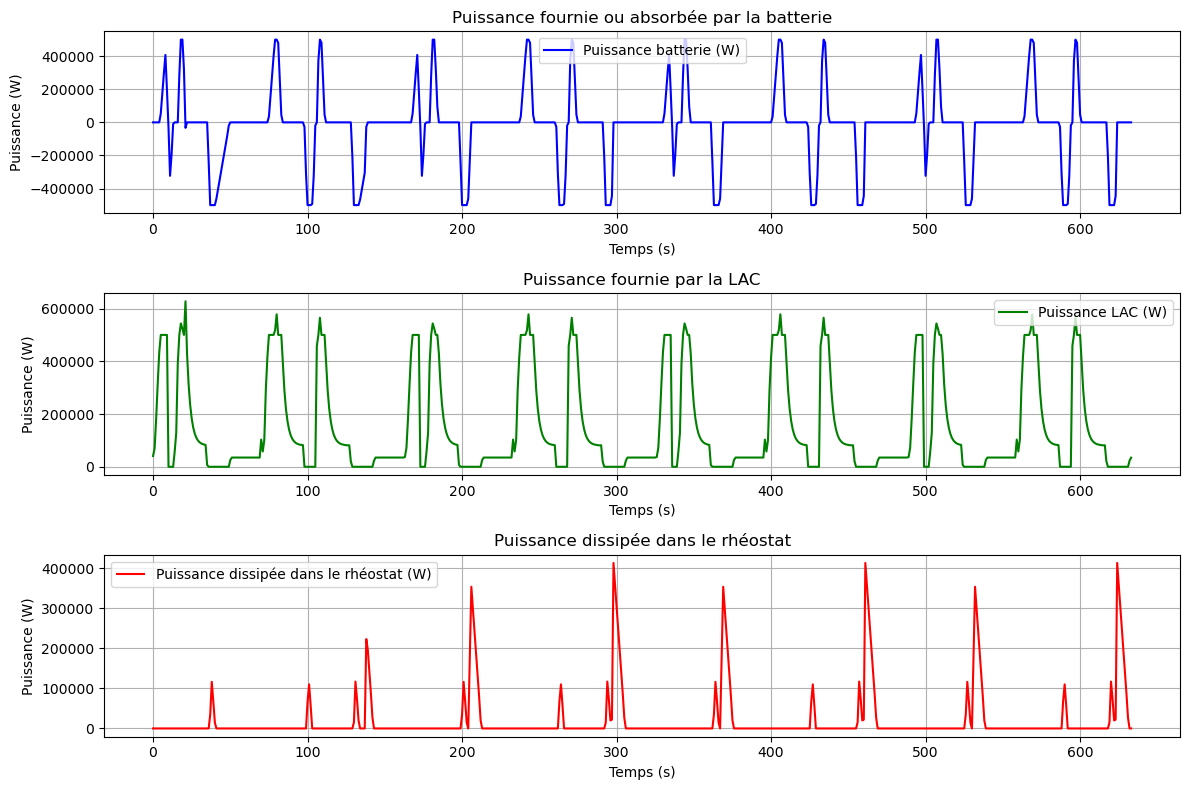

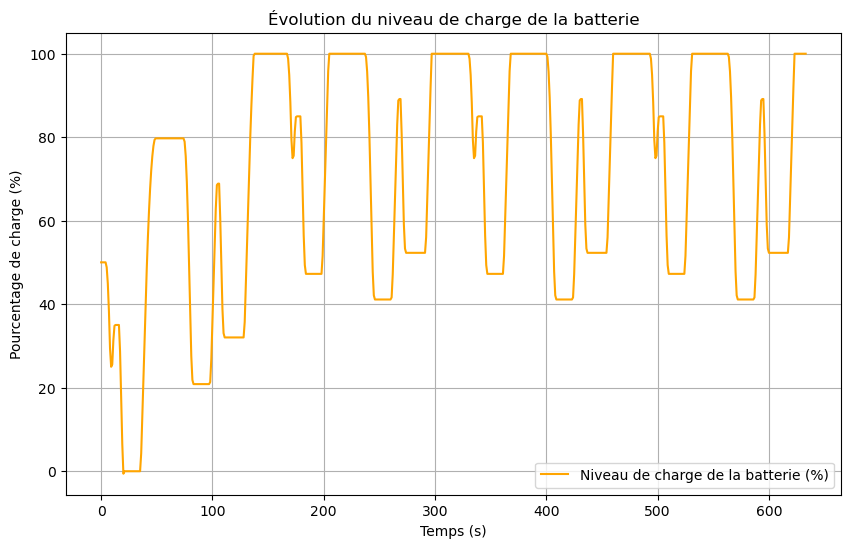

In [137]:
# AFFICHAGE
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(temps, P_battery_list, label='Puissance batterie (W)', color='blue')
plt.title('Puissance fournie ou absorbée par la batterie')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(temps, P_LAC_list, label='Puissance LAC (W)', color='green')
plt.title('Puissance fournie par la LAC')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(temps, P_rheostat_list, label='Puissance dissipée dans le rhéostat (W)', color='red')
plt.title('Puissance dissipée dans le rhéostat')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


battery_levels_np = np.array(battery_levels)
battery_prctg = 100 * battery_levels_np / battery_capacity

plt.figure(figsize=(10, 6))
plt.plot(temps, battery_prctg, label='Niveau de charge de la batterie (%)', color='orange')
plt.title('Évolution du niveau de charge de la batterie')
plt.xlabel('Temps (s)')
plt.ylabel('Pourcentage de charge (%)')
plt.legend()
plt.grid(True)
plt.show()

# MONTE CARLO

Monte Carlo Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 398.83it/s]


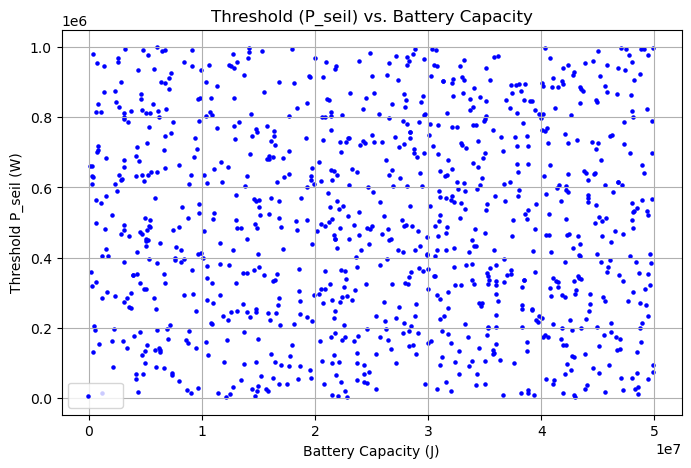

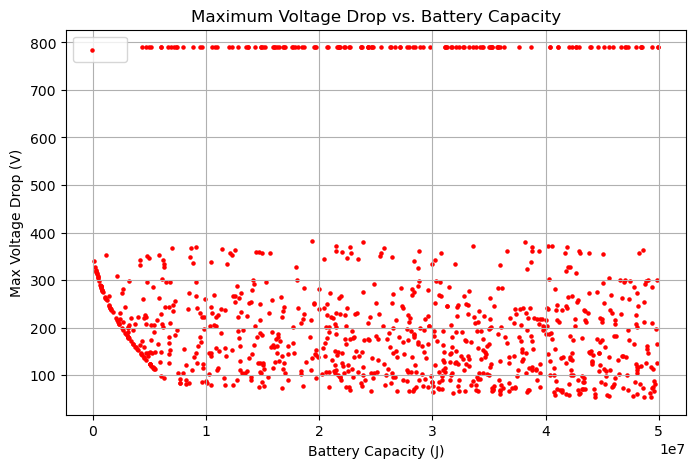

In [148]:
from tqdm import tqdm
def monte_carlo_iteration(
    capacity_range,
    P_seil_range,
    gestion_puissances,
    temps,
    position_x,
    Ptrain,
    Vsst,
    calculer_Req,
    Dt
):    
    
    battery_capacity = np.random.uniform(capacity_range[0], capacity_range[1])
    P_seil = np.random.uniform(P_seil_range[0], P_seil_range[1])
    
    battery_output_capacity = battery_capacity * 0.1
    battery_input_capacity = battery_capacity * 0.1
    
    battery_level = battery_capacity / 2.0
    chute_de_tension_list = []
    

    for idx in range(len(temps)):
        x = position_x[idx]
        train_demand = Ptrain[idx]
        
        RCeq = calculer_Req(x)
        
        P_battery, P_LAC, P_rheostat, battery_level = gestion_puissances(
            P_seil,
            train_demand,
            battery_level,
            battery_capacity,
            battery_output_capacity,
            battery_input_capacity,
            Dt
        )
        
        delta = Vsst**2 - 4 * RCeq * P_LAC
        if delta >= 0:
            Vtrain = 0.5 * (Vsst + np.sqrt(delta))
        else:
            Vtrain = 0
            
        chute_tension = Vsst - Vtrain
        chute_de_tension_list.append(chute_tension)
    
    chute_de_tension_max = max(chute_de_tension_list)
    return (battery_capacity, P_seil, chute_de_tension_max)


def run_monte_carlo(n_iterations, capacity_range, P_seil_range, *args):
    results = []
    
    for _ in tqdm(range(n_iterations), desc="Monte Carlo Iterations"):
        result = monte_carlo_iteration(capacity_range, P_seil_range, *args)
        results.append(result)
        
    return results


capacity_range = (0, 50000000)  # in Joules
P_seil_range = (0, 1000000)     # in Watts
n_iterations = 1000

# Run Monte Carlo simulation
results = run_monte_carlo(
    n_iterations,
    capacity_range,
    P_seil_range,
    gestion_puissances,
    temps,
    position_x,
    Ptrain,
    Vsst,
    calculer_Req,
    Dt
)

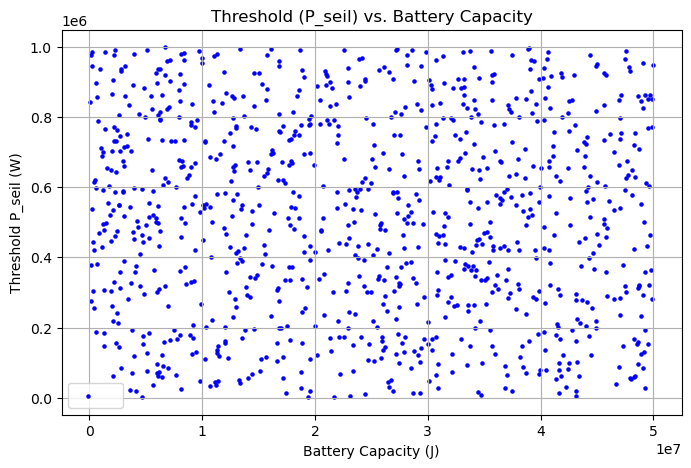

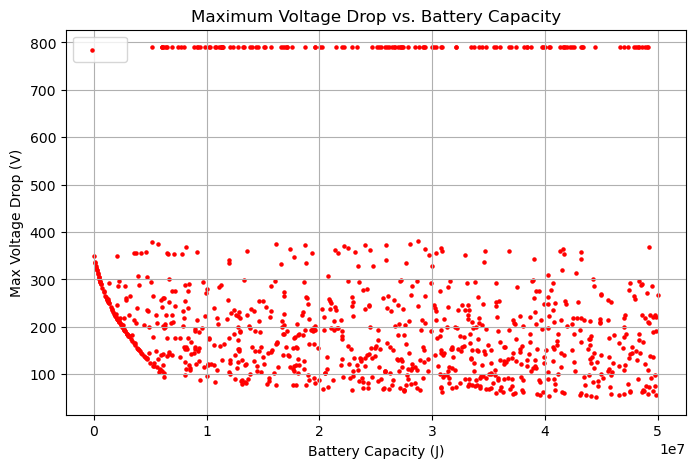

In [147]:
def plot_results(results):
    # Separate the data into individual lists for convenience
    capacities = [item[0] for item in results]
    p_seils = [item[1] for item in results]
    voltage_drops = [item[2] for item in results]
    # -----------------------------------
    # Figure 1: Plot of P_seil vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    plt.scatter(capacities, p_seils, c='blue', s=5, label=' ')
    plt.title("Threshold (P_seil) vs. Battery Capacity")
    plt.xlabel("Battery Capacity (J)")
    plt.ylabel("Threshold P_seil (W)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # -----------------------------------
    # Figure 2: Plot of max voltage drop vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    plt.scatter(capacities, voltage_drops, c='red', s=5, label=' ')
    plt.title("Maximum Voltage Drop vs. Battery Capacity")
    plt.xlabel("Battery Capacity (J)")
    plt.ylabel("Max Voltage Drop (V)")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_results(results)
